# COVID by county

This code plots simple time series data of cases and deaths made available from the  NYTimes (see [here](https://github.com/nytimes/covid-19-data)).

New cases and new deaths for each day are determined from subtracting the cases of a day from the previous day. These are raw numbers and not per capita which is important to put in context. In addition, the numbers are likely underestimated since widespread testing is not yet available.

I created this as a simple way to update friends and family early in the early stages of the pandemic. However, I encourage you to go to [covid19-projections.com](https://covid19-projections.com) for one of the most reliable models to forecast coronavirus cases.

In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

# Import data from NYTimes



In [21]:
os.chdir(
    "/Users/lacar/Documents/Data_science/Jupyter_notebooks/covid_2020/covid-19-data/"
)

<IPython.core.display.Javascript object>

In [22]:
!git pull

Already up to date.


<IPython.core.display.Javascript object>

In [23]:
os.chdir("/Users/lacar/Documents/Data_science/Jupyter_notebooks/covid_2020/")

<IPython.core.display.Javascript object>

In [24]:
df_covid = pd.read_csv("covid-19-data/us-counties.csv")
df_covid["county_state"] = df_covid["county"] + " County, " + df_covid["state"]

<IPython.core.display.Javascript object>

In [25]:
df_covid.head()

,date,county,state,fips,cases,deaths,county_state
0,2020-01-21,Snohomish,Washington,53061.0,1,0,"Snohomish County, Washington"
1,2020-01-22,Snohomish,Washington,53061.0,1,0,"Snohomish County, Washington"
2,2020-01-23,Snohomish,Washington,53061.0,1,0,"Snohomish County, Washington"
3,2020-01-24,Cook,Illinois,17031.0,1,0,"Cook County, Illinois"
4,2020-01-24,Snohomish,Washington,53061.0,1,0,"Snohomish County, Washington"


<IPython.core.display.Javascript object>

# Reorganize tables

In [26]:
def filter_data(states_list, county_list):
    df_covid_states = df_covid[df_covid["state"].isin(states_list)].copy()
    df_covid_states_county = df_covid_states[
        df_covid_states["county_state"].isin(county_list)
    ].copy()
    df_covid_states_county.sort_values(by=["county_state", "date"], inplace=True)
    df_covid_states_county.reset_index(inplace=True, drop=True)

    # Add new cases, deaths - do manually
    for i in df_covid_states_county.index:
        try:
            county_row = df_covid_states_county.loc[i, "county_state"]
            county_rowahead = df_covid_states_county.loc[i + 1, "county_state"]
            cases_row = df_covid_states_county.loc[i, "cases"]
            cases_rowahead = df_covid_states_county.loc[i + 1, "cases"]
            deaths_row = df_covid_states_county.loc[i, "deaths"]
            deaths_rowahead = df_covid_states_county.loc[i + 1, "deaths"]

            if county_rowahead == county_row:
                df_covid_states_county.loc[i + 1, "new_cases"] = (
                    cases_rowahead - cases_row
                )
                df_covid_states_county.loc[i + 1, "new_deaths"] = (
                    deaths_rowahead - deaths_row
                )
        except:
            continue

    return df_covid_states_county

<IPython.core.display.Javascript object>

In [27]:
def reorg_table_by_category(df_county_state_lim, category):
    # Re-org table
    df_covid_states_county_by_date_county_category = (
        df_county_state_lim.groupby(["date", "county_state"]).sum()[category].unstack()
    )
    df_covid_states_county_by_date_county_category.dropna(how="all", inplace=True)
    df_covid_states_county_by_date_county_category.reset_index(inplace=True)
    return df_covid_states_county_by_date_county_category

<IPython.core.display.Javascript object>

# Visualize

In [28]:
def plot_by_category(
    df_county_state_lim, df_category, category, title, starting_ind, ax
):

    for county in df_county_state_lim["county_state"].unique().tolist():
        ax.plot(df_category["date"], df_category[county], label=county)

    # Make labels easier to read by only showing every other
    date_list = df_category["date"].tolist()
    labels = [v if i % 2 == 0 else " " for i, v in enumerate(date_list)]
    # labels = df_category["date"]
    ax.set_xticklabels(labels, rotation=90, fontsize=14)
    ax.set_xlim(starting_ind, len(df_category))
    ax.legend(fontsize=12)
    ax.set_ylabel(category, fontsize=18)
    ax.set_title(title, fontsize=18)
    # plt.tight_layout()

    return county, df_category["date"], df_category[county]

<IPython.core.display.Javascript object>

In [29]:
def plot_all_categories_for_county(states_list, county_list, starting_date):    
    # Get filtered data
    filt_data = filter_data(states, counties)
        
    # Re-org table
    df_covid_sc_bydate_county_cases = reorg_table_by_category(
        filt_data, "cases"
    )
    df_covid_sc_bydate_county_newcases = reorg_table_by_category(
        filt_data, "new_cases"
    )
    df_covid_sc_bydate_county_deaths = reorg_table_by_category(
        filt_data, "deaths"
    )
    df_covid_sc_bydate_county_newdeaths = reorg_table_by_category(
        filt_data, "new_deaths"
    )

    df_category_list = [df_covid_sc_bydate_county_cases, df_covid_sc_bydate_county_newcases, df_covid_sc_bydate_county_deaths, df_covid_sc_bydate_county_newdeaths]
    category_list = ['cases', 'new_cases', 'deaths', 'new_deaths']
    category_title_list = ['cases (cumulative)', 'new_cases', 'deaths (cumulative)', 'new_deaths']
    
    index_starting_date = df_covid_sc_bydate_county_cases[df_covid_sc_bydate_county_cases["date"] == starting_date].index.tolist()[0]
    
    fig, ax = plt.subplots(4, 1, figsize=(12, 16))
      
    for i, category_df in enumerate(df_category_list):
        plot_by_category(
            filt_data,
            category_df,
            category_list[i],
            category_title_list[i],
            index_starting_date,
            ax[i],
        )
    plt.tight_layout()


<IPython.core.display.Javascript object>

# Inputs with different locations

## Local

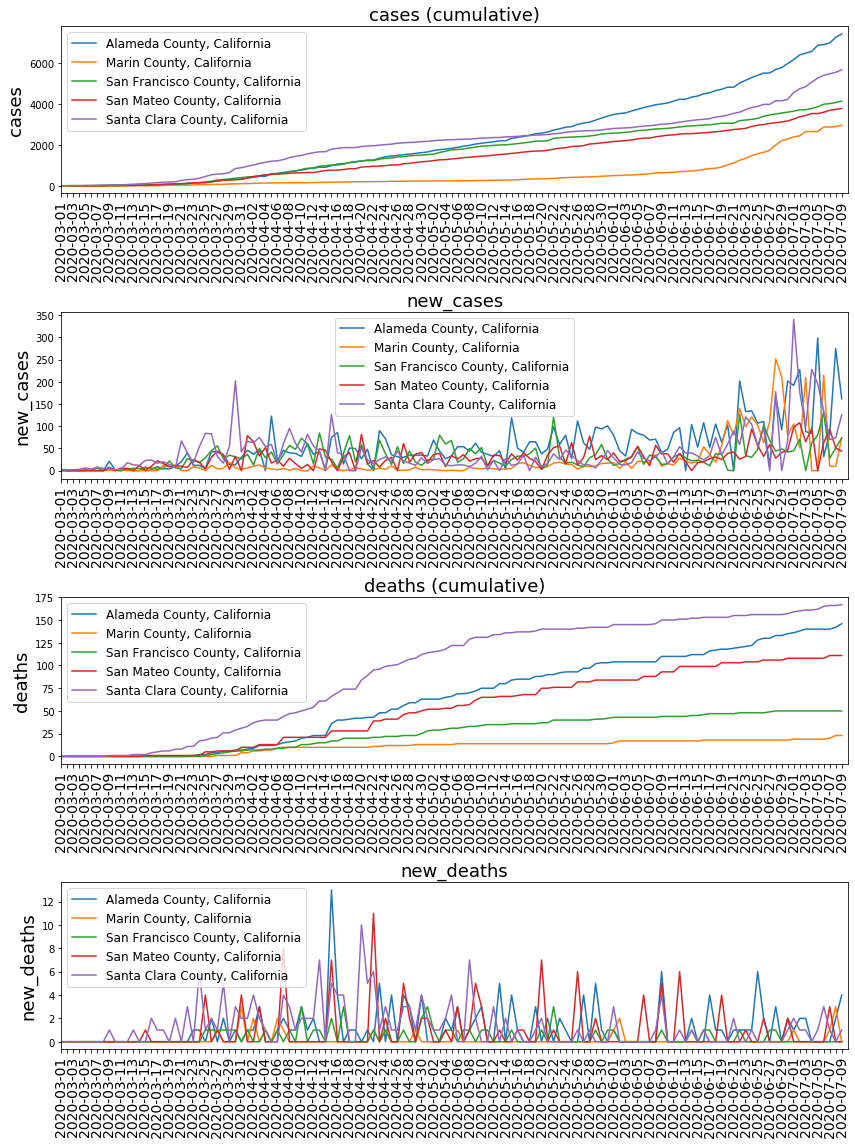

<IPython.core.display.Javascript object>

In [30]:
states = ["California"]
counties = [
    "San Francisco County, California",
    "San Mateo County, California",
    "Santa Clara County, California",
    "Alameda County, California",
    "Marin County, California",
]
plot_all_categories_for_county(states, counties, "2020-03-01")

## Some CA, AZ counties

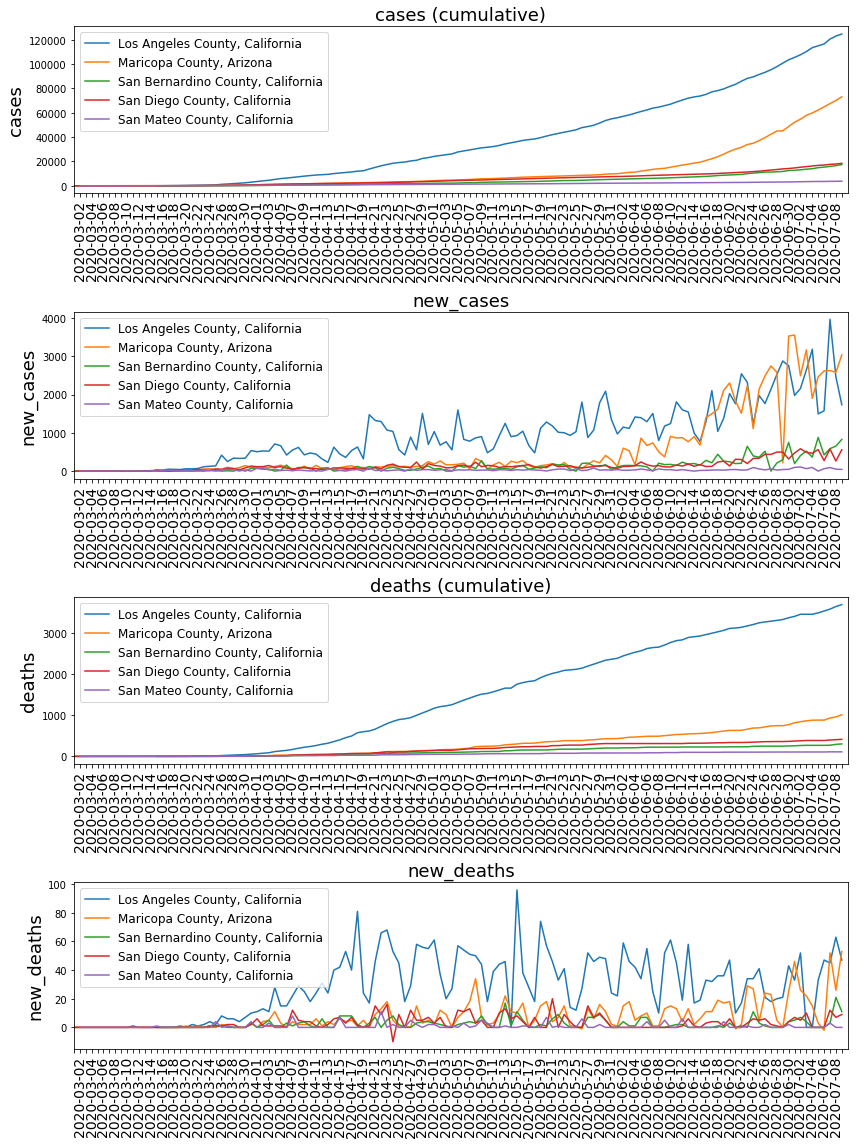

<IPython.core.display.Javascript object>

In [31]:
states = ["California", "Arizona"]
counties = [
    "San Bernardino County, California",
    "San Diego County, California",
    "San Mateo County, California",
    "Los Angeles County, California",
    "Maricopa County, Arizona",
]
plot_all_categories_for_county(states, counties, "2020-03-01")

## CA and some East Coast

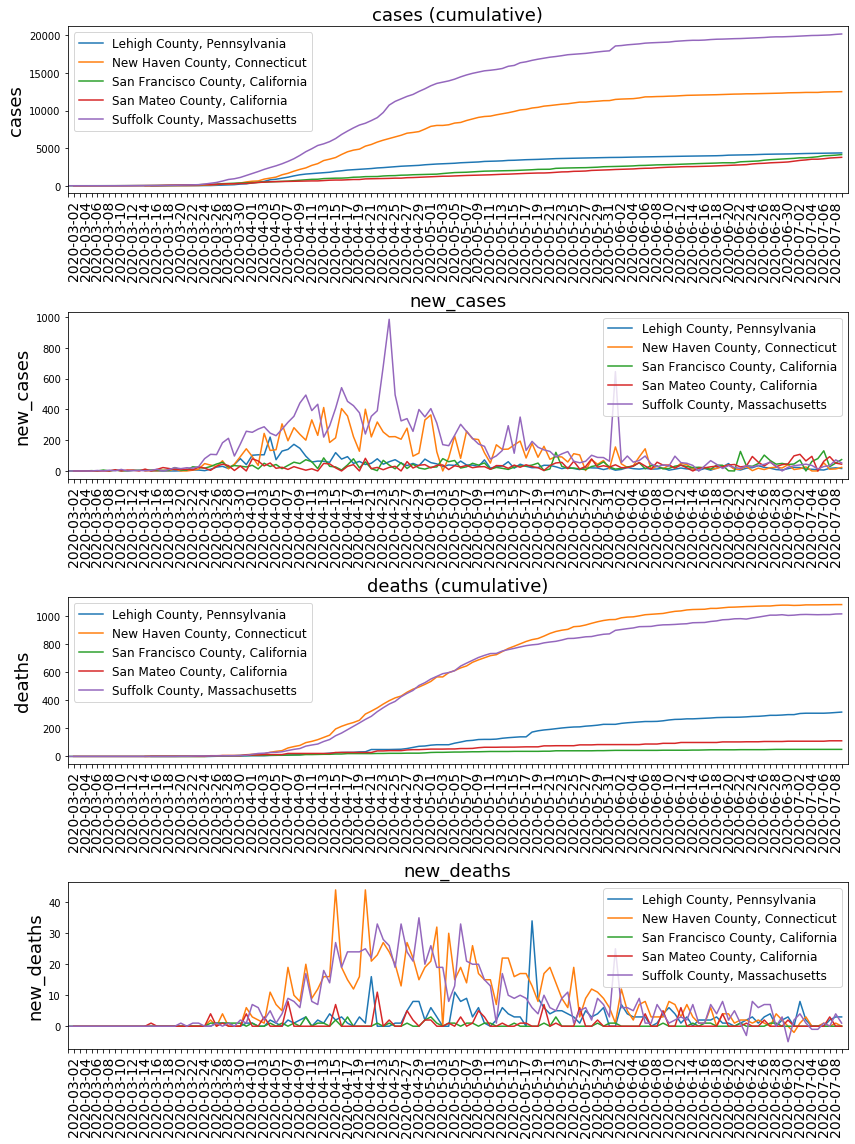

<IPython.core.display.Javascript object>

In [32]:
states = ["Pennsylvania", "Connecticut", "California", "Massachusetts"]
counties = [
    "Suffolk County, Massachusetts",
    "New Haven County, Connecticut",
    "Lehigh County, Pennsylvania",
    "San Francisco County, California",
    "San Mateo County, California",
]
plot_all_categories_for_county(states, counties, "2020-03-01")

## New York only

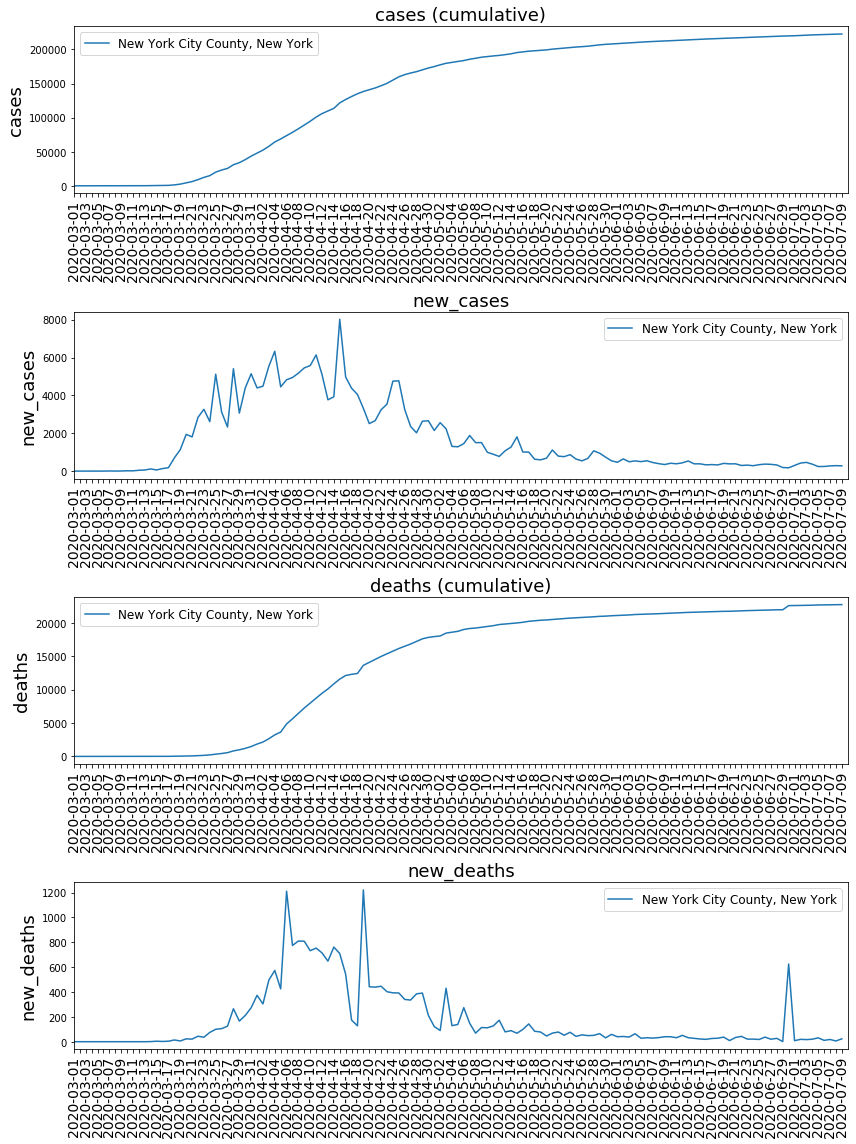

<IPython.core.display.Javascript object>

In [33]:
states = ["New York"]
counties = [
    "New York City County, New York",
]
plot_all_categories_for_county(states, counties, "2020-03-01")

## CA, CO, PA, Southeast

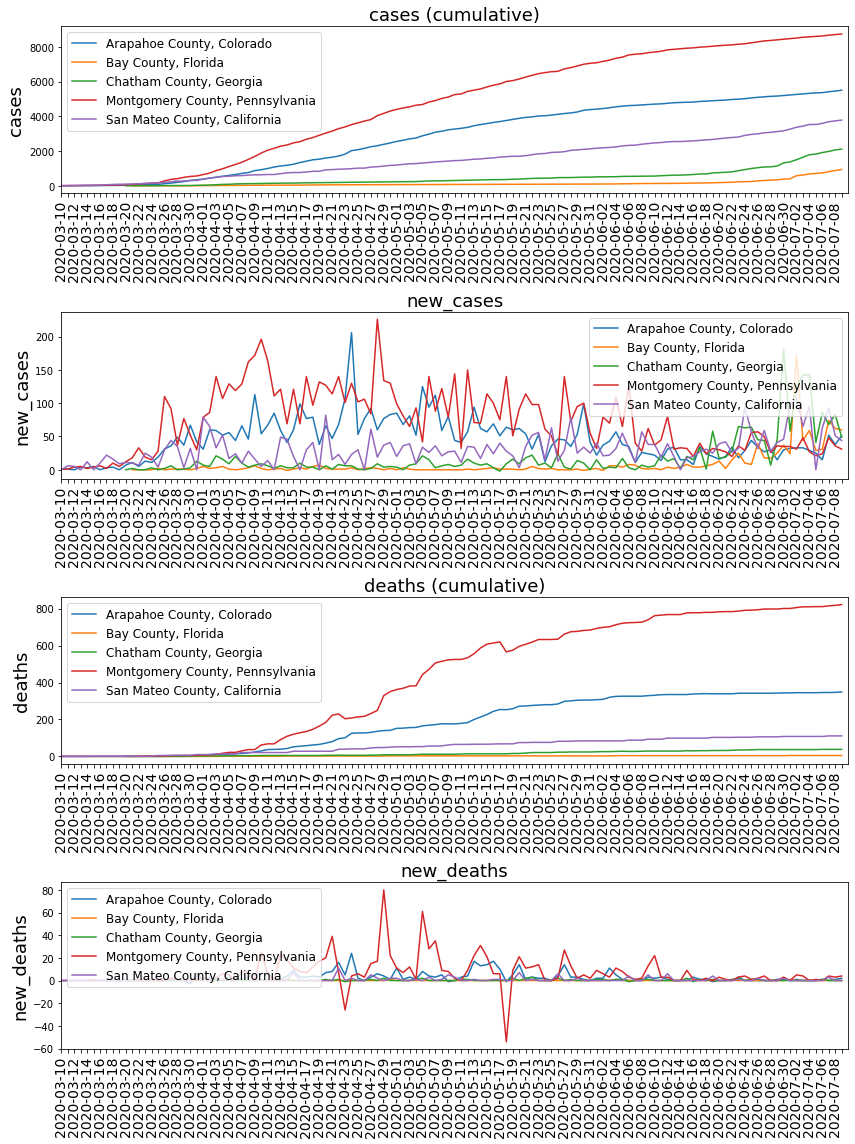

<IPython.core.display.Javascript object>

In [34]:
states = ["Colorado", "California", "Pennsylvania", "Georgia", "Florida"]
counties = [
    "Arapahoe County, Colorado",
    "Chatham County, Georgia",
    "Montgomery County, Pennsylvania",
    "Leon Countydd, Florida",
    "Bay County, Florida",
    "San Mateo County, California",
]
plot_all_categories_for_county(states, counties, "2020-03-10")

## CA, WA, Las Vegas

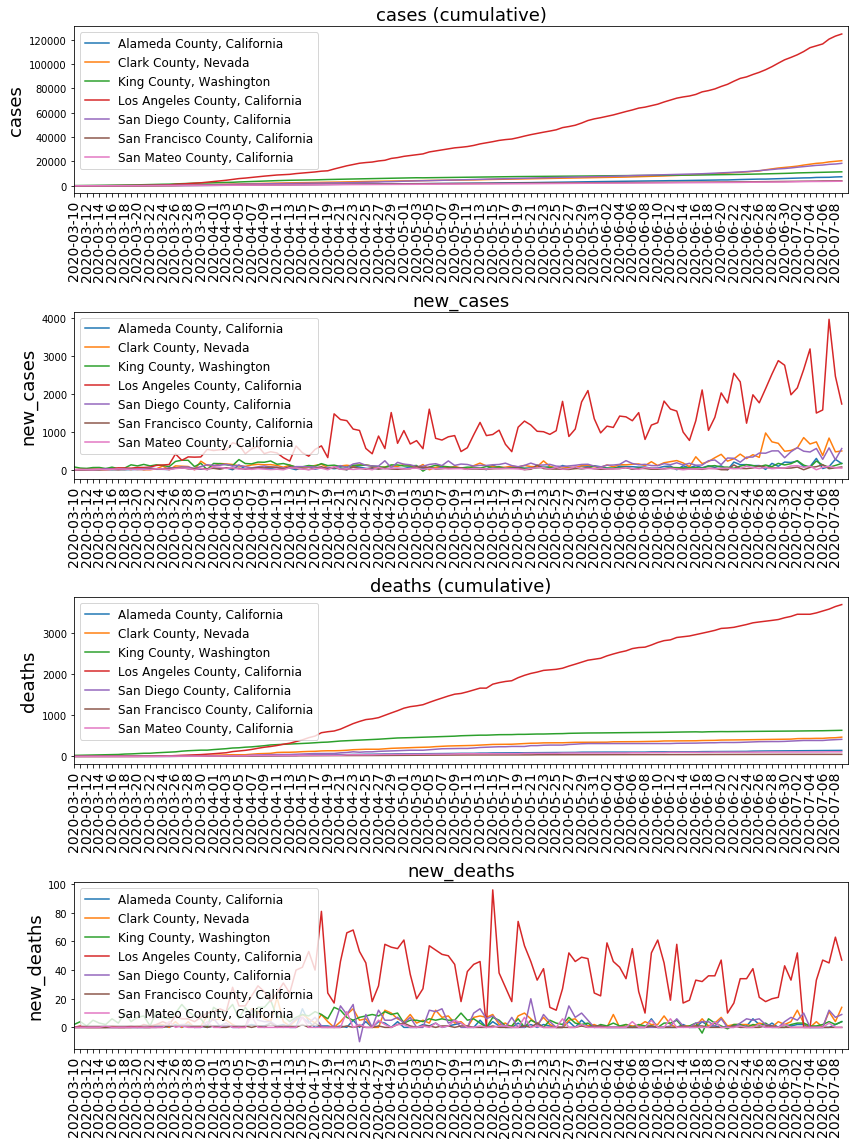

<IPython.core.display.Javascript object>

In [35]:
states = ["Nevada", "California", "Washington"]
counties = [
    "Clark County, Nevada",
    "King County, Washington",
    "Los Angeles County, California",
    "San Francisco County, California",
    "San Mateo County, California",
    "Alameda County, California",
    "San Diego County, California",
]
plot_all_categories_for_county(states, counties, "2020-03-10")

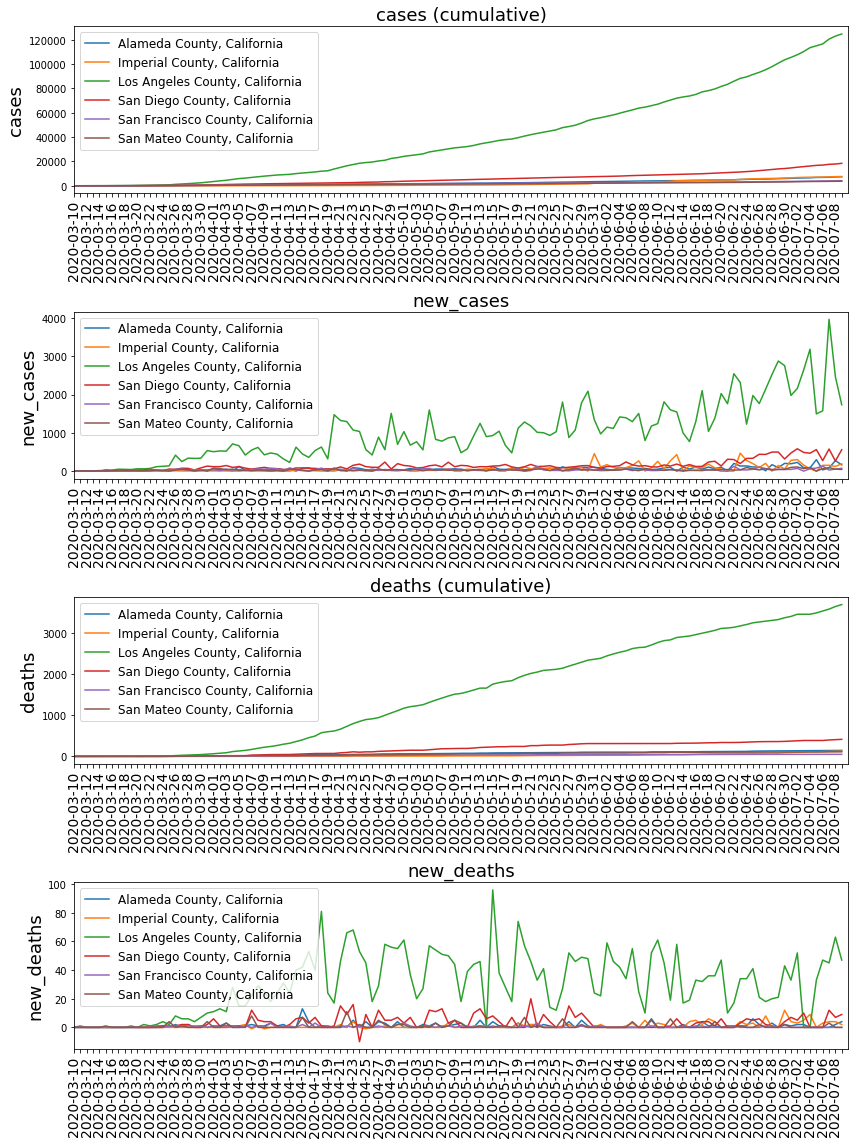

<IPython.core.display.Javascript object>

In [36]:
states = ["California"]
counties = [
    "Imperial County, California",
    "Los Angeles County, California",
    "San Francisco County, California",
    "San Mateo County, California",
    "Alameda County, California",
    "San Diego County, California",
]
plot_all_categories_for_county(states, counties, "2020-03-10")

In [37]:
!git commit -a -m "update"
!git push

[master 2a2655c] update
 1 file changed, 489 insertions(+), 140 deletions(-)
Counting objects: 3, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 3.04 KiB | 53.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/benslack19/covid_cases_by_county.git
   0d694ab..2a2655c  master -> master


<IPython.core.display.Javascript object>